# EDA - Identify significant predictors
- Edited by Rumi Nakagawa
- Spring 2023 Capstone

## SITE US-vcp
- ENF  Evergreen Needleleaf Forests
- metadata

|     | site_id |   dataset | start_year | end_year |                                              file | is_dup | IGBP | elevation |      lat |       long |
|----:|--------:|----------:|-----------:|---------:|--------------------------------------------------:|-------:|-----:|----------:|---------:|-----------:|
| 206 |  US-Vcp | AmeriFlux |       2007 |     2017 | FLX_US-Vcp_FLUXNET2015_FULLSET_MM_2007-2017_be... |  False |  ENF |    2542.0 | 35.86240 | -106.59740 |

# 0. Preparation

## Mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


## Import libraries

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=df1bdb801ee582f0fcc13bae66d7458a433d42c12d6587edc1a2b81486998016
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
# !pip install dython

In [5]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [6]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [7]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [8]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pyspark.sql.functions import desc

import geopandas as gpd
import folium

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.ml.classification import RandomForestClassifier
import time
# from dython import nominal

# Apply the default theme
sns.set_theme()


## (to be updated) Get access to blob storage
- Reference from 261

In [ ]:
# Put at the top of any notebooks for storing in blob

# from pyspark.sql.functions import col, max

# blob_container = "team06" # The name of your container created in https://portal.azure.com
# storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
# secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
# secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
# blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
# mount_path = "/mnt/mids-w261"

## Import csv
sample csv

In [15]:
monthly_df = pd.read_csv("data_monthly_v1_0_mydrive.csv")
# Copied original file. It is needed to store in each user's mydrive

In [16]:
monthly_df

,SITE_ID,year,month,TIMESTAMP,dataset,SITE_IGBP,LOCATION_LAT,LOCATION_LONG,TA_F,VPD_F,...,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,koppen_sub,koppen,CO2_concentration
0,AR-SLu,2010,1,201001,FLUXNET,MF,-33.46480,-66.45980,28.493,23.378,...,0.000000,0.49,1.2,313.84,293.58,OSH,SH,BSk,Arid,387.110
1,AR-SLu,2010,2,201002,FLUXNET,MF,-33.46480,-66.45980,26.673,14.369,...,0.000000,0.43,0.9,309.86,292.96,OSH,SH,BSk,Arid,387.675
2,AR-SLu,2010,3,201003,FLUXNET,MF,-33.46480,-66.45980,25.744,15.167,...,0.000000,0.41,0.8,309.18,290.52,OSH,SH,BSk,Arid,388.195
3,AR-SLu,2010,4,201004,FLUXNET,MF,-33.46480,-66.45980,18.450,9.185,...,0.000000,0.36,0.5,303.24,286.34,OSH,SH,BSk,Arid,388.905
4,AR-SLu,2010,5,201005,FLUXNET,MF,-33.46480,-66.45980,13.493,5.823,...,0.000000,0.37,0.5,296.20,277.82,OSH,SH,BSk,Arid,389.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,SE-Lnn,2018,8,201808,ICOS2018,CRO,58.34063,13.10177,16.767,5.483,...,0.000000,0.28,0.5,296.66,282.84,CRO,CRO,Dfb,Cold,406.525
19011,SE-Lnn,2018,9,201809,ICOS2018,CRO,58.34063,13.10177,11.719,2.344,...,0.000000,0.43,0.7,290.18,280.78,CRO,CRO,Dfb,Cold,405.985
19012,SE-Lnn,2018,10,201810,ICOS2018,CRO,58.34063,13.10177,7.827,1.575,...,0.000000,0.54,1.0,284.16,276.10,CRO,CRO,Dfb,Cold,406.280
19013,SE-Lnn,2018,11,201811,ICOS2018,CRO,58.34063,13.10177,3.794,0.563,...,0.800000,NaN,NaN,277.06,270.88,CRO,CRO,Dfb,Cold,407.320


In [23]:
print(len(monthly_df.columns))
monthly_df.columns

62


Index(['SITE_ID', 'year', 'month', 'TIMESTAMP', 'dataset', 'SITE_IGBP',
       'LOCATION_LAT', 'LOCATION_LONG', 'TA_F', 'VPD_F', 'P_F', 'NETRAD',
       'NEE_VUT_REF', 'NEE_VUT_REF_QC', 'NEE_CUT_REF', 'NEE_CUT_REF_QC',
       'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF',
       'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF',
       'RECO_DT_CUT_REF', 'time', 'ET', 'BESS-PAR', 'BESS-PARdiff',
       'BESS-RSDN', 'CSIF-SIFdaily', 'CSIF-SIFinst', 'PET', 'Ts', 'Tmean',
       'prcp', 'vpd', 'prcp-lag3', 'ESACCI-sm', 'MODIS_LC', 'b1', 'b2', 'b3',
       'b4', 'b5', 'b6', 'b7', 'EVI', 'GCI', 'NDVI', 'NDWI', 'NIRv', 'kNDVI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP',
       'MODIS_PFT', 'koppen_sub', 'koppen', 'CO2_concentration'],
      dtype='object')

In [46]:
# Features used for this analysis

output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_CUT_REF', 'GPP_NT_VUT_REF',
                      'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF','GPP_DT_CUT_REF',
                      'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 
                      'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF']

# predictor variables
pred_var_numeric = ['TA_F', 'VPD_F', 'P_F', 'NETRAD','ET',
                    'BESS-PAR', 'BESS-PARdiff','BESS-RSDN', 
                    'CSIF-SIFdaily', 'CSIF-SIFinst','PET', 'Ts', 'Tmean',
                    'prcp', 'vpd', 'prcp-lag3', 'ESACCI-sm',
                    'b1', 'b2', 'b3','b4', 'b5', 'b6', 'b7', 
                    'EVI', 'GCI', 'NDVI', 'NDWI', 'NIRv', 'kNDVI',
                    'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 
                    'CO2_concentration']

pred_var_categorical = ['MODIS_LC', 'MODIS_IGBP','MODIS_PFT', 'koppen_sub', 'koppen']

other_var =  ['SITE_ID', 'year', 'month', 'TIMESTAMP', 'dataset', 'SITE_IGBP',
              'LOCATION_LAT', 'LOCATION_LONG','time']

qc_flags = ['NEE_VUT_REF_QC', 'NEE_CUT_REF_QC'] 

NA_list = []

len(output_related_var + pred_var_numeric + pred_var_categorical 
    + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

62

In [47]:
# Check if all the features are included in one of the four
total = output_related_var + pred_var_numeric + pred_var_categorical + other_var + qc_flags + NA_list
for i in monthly_df.columns:
  if i not in total:
    print(i)

### Reference: Distribution of QC flag
- Original dataset

[Text(0.5, 1.0, 'NEE_CUT_REF_QC')]

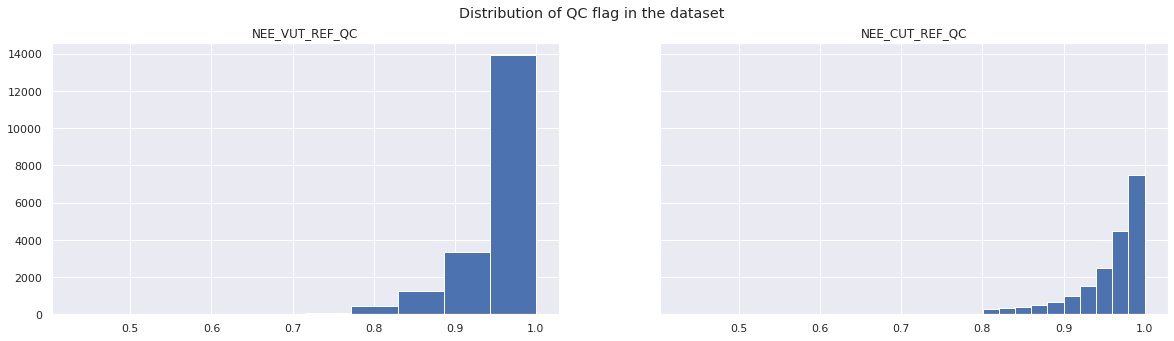

In [81]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,5))

fig.suptitle('Distribution of QC flag in the dataset')
monthly_df['NEE_VUT_REF_QC'].hist(ax=axes[0]).set(title='NEE_VUT_REF_QC')
monthly_df['NEE_CUT_REF_QC'].hist(ax=axes[1]).set(title='NEE_CUT_REF_QC')

## Preprocess features

In [82]:
# Original columns
print(len(monthly_df.columns))
monthly_df.columns

62


Index(['SITE_ID', 'year', 'month', 'TIMESTAMP', 'dataset', 'SITE_IGBP',
       'LOCATION_LAT', 'LOCATION_LONG', 'TA_F', 'VPD_F', 'P_F', 'NETRAD',
       'NEE_VUT_REF', 'NEE_VUT_REF_QC', 'NEE_CUT_REF', 'NEE_CUT_REF_QC',
       'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF',
       'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF',
       'RECO_DT_CUT_REF', 'time', 'ET', 'BESS-PAR', 'BESS-PARdiff',
       'BESS-RSDN', 'CSIF-SIFdaily', 'CSIF-SIFinst', 'PET', 'Ts', 'Tmean',
       'prcp', 'vpd', 'prcp-lag3', 'ESACCI-sm', 'MODIS_LC', 'b1', 'b2', 'b3',
       'b4', 'b5', 'b6', 'b7', 'EVI', 'GCI', 'NDVI', 'NDWI', 'NIRv', 'kNDVI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP',
       'MODIS_PFT', 'koppen_sub', 'koppen', 'CO2_concentration'],
      dtype='object')

## Check how much NA/None exists in each column

In [83]:
monthly_df.isna().sum()

SITE_ID              0
year                 0
month                0
TIMESTAMP            0
dataset              0
                    ..
MODIS_IGBP           0
MODIS_PFT            0
koppen_sub           0
koppen               0
CO2_concentration    0
Length: 62, dtype: int64

In [84]:
monthly_df_countNA = monthly_df.isna().sum()
monthly_df_countNA

SITE_ID              0
year                 0
month                0
TIMESTAMP            0
dataset              0
                    ..
MODIS_IGBP           0
MODIS_PFT            0
koppen_sub           0
koppen               0
CO2_concentration    0
Length: 62, dtype: int64

In [85]:
monthly_df_countNA = pd.DataFrame(monthly_df.isna().sum())

NA0_list = list(monthly_df_countNA[monthly_df_countNA[0] == 0].index)
NA_list = list(monthly_df_countNA[monthly_df_countNA[0] != 0].index)

In [87]:
len(monthly_df)

19015

In [86]:
monthly_df_countNA[monthly_df_countNA[0] != 0]

,0
P_F,353
NETRAD,2693
RECO_DT_VUT_REF,1
RECO_DT_CUT_REF,1
ET,32
CSIF-SIFdaily,121
CSIF-SIFinst,121
PET,101
Ts,101
Tmean,101


In [ ]:
# NA list in site us_vcp
NA_list = ['G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS_QC', 'LE_CORR', 'H_F_MDS_QC',
           'H_CORR','SW_DIF']

['NETRAD',
 'PPFD_IN',
 'G_F_MDS',
 'G_F_MDS_QC',
 'LE_F_MDS_QC',
 'LE_CORR',
 'H_F_MDS_QC',
 'H_CORR',
 'NEE_VUT_REF_qa',
 'SW_DIF',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7']

### Predictor variables(candidates)

| feature_name      |                       source                       | definition                                                                                                                                                                              | var_type    |   |
|-------------------|:--------------------------------------------------:|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|---|
| TA_F              | FLUXNET                                            | Air temperature, consolidated from TA_F_MDS and TA_ERA                                                                                                                                  | numeric     |   |
| VPD_F             | FLUXNET                                            | Vapor Pressure Deficit consolidated from VPD_F_MDS and VPD_ERA                                                                                                                          | numeric     |   |
| P_F               | FLUXNET                                            | Precipitation consolidated from P and P_ERA                                                                                                                                             | numeric     |   |
| NETRAD            | FLUXNET                                            | Net radiation                                                                                                                                                                           | numeric     |   |
| BESS-PAR          | BESS PAR                                           | Photosynthetic Active Radiation (PAR)                                                                                                                                                   | numeric     |   |
| BESS-PARdiff      | BESS PAR                                           | Diffuse PAR                                                                                                                                                                             | numeric     |   |
| BESS-RSDN         | BESS PAR                                           | Shortwave downwelling radiation                                                                                                                                                         | numeric     |   |
| CSIF-SIFdaily     | CSIF                                               | All-sky daily average SIF                                                                                                                                                               | numeric     |   |
| CSIF-SIFinst      | NA                                                 | NA                                                                                                                                                                                      | numeric     |   |
| PET               | ERA5-Land                                          | Potential ET                                                                                                                                                                            | numeric     |   |
| Ts                | ERA5-Land                                          | NA                                                                                                                                                                                      | numeric     |   |
| Tmean             | ERA5-Land                                          | Air temperature                                                                                                                                                                         | numeric     |   |
| prcp              | ERA5-Land                                          | Precipitation                                                                                                                                                                           | numeric     |   |
| vpd               | ERA5-Land                                          | Vapor pressure deficit                                                                                                                                                                  | numeric     |   |
| prcp-lag3         | ERA5-Land                                          | Precipitation 3-month lag                                                                                                                                                               | numeric     |   |
| ESACCI-sm         | ERA5-Land                                          | Soil moisture                                                                                                                                                                           | numeric     |   |
| MODIS_LC          | NA                                                 | MODIS land cover (MODIS LC)                                                                                                                                                             | categorical |   |
| b1                | MCD43C4                                            | Surface reflectance Band 1                                                                                                                                                              | numeric     |   |
| b2                | MCD43C4                                            | Surface reflectance Band 2 (nir)                                                                                                                                                        | numeric     |   |
| b3                | MCD43C4                                            | Surface reflectance Band 3 (blue)                                                                                                                                                       | numeric     |   |
| b4                | MCD43C4                                            | Surface reflectance Band 4 (green)                                                                                                                                                      | numeric     |   |
| b5                | MCD43C4                                            | Surface reflectance Band 5 (SWIR1)                                                                                                                                                      | numeric     |   |
| b6                | MCD43C4                                            | Surface reflectance Band 6 (SWIR2)                                                                                                                                                      | numeric     |   |
| b7                | MCD43C4                                            | Surface reflectance Band 7 (SWIR3)                                                                                                                                                      | numeric     |   |
| EVI               | MCD43C4                                            | Enhanced Vegetation Index (EVI)                                                                                                                                                         | numeric     |   |
| GCI               | MCD43C4                                            | CIGreen c                                                                                                                                                                               | numeric     |   |
| NDVI              | MCD43C4                                            | Normalized Difference Vegetation Index (NDVI)                                                                                                                                           | numeric     |   |
| NDWI              | MCD43C4                                            | Normalized Different Water Index (NDWI) b                                                                                                                                               | numeric     |   |
| NIRv              | MCD43C4                                            | NIRv d                                                                                                                                                                                  | numeric     |   |
| kNDVI             | MCD43C4                                            | kNDVI a                                                                                                                                                                                 | numeric     |   |
| Percent_Snow      | MCD43C4                                            | Percentage of snow cover                                                                                                                                                                | numeric     |   |
| Fpar              | MCD15A3H (after 2002/07) MOD15A2H (before 2002/07) | Fraction of photosynthetically active radiation (fPAR)                                                                                                                                  | numeric     |   |
| Lai               | MCD15A3H (after 2002/07) MOD15A2H (before 2002/07) | Surface reflectance Band 7 (SWIR3)                                                                                                                                                      | numeric     |   |
| LST_Day           | MYD11A1 (after 2002/07) MOD11A1 (before 2002/07)   | Daytime land surface temperature                                                                                                                                                        | numeric     |   |
| LST_Night         | MYD11A1 (after 2002/07) MOD11A1 (before 2002/07)   | Nighttime land surface temperature                                                                                                                                                      | numeric     |   |
| MODIS_IGBP        | NA                                                 | NA                                                                                                                                                                                      | categorical |   |
| MODIS_PFT         | NA                                                 | NA                                                                                                                                                                                      | categorical |   |
| koppen_sub        | NA                                                 | NA                                                                                                                                                                                      | categorical |   |
| koppen            | Koppen-Geiger                                      | Climate zone (one-hot encoding)                                                                                                                                                         | categorical |   |
| CO2_concentration | ESLR                                               | Atmospheric CO2 concentration                                                                                                                                                           | numeric     |   |

# Correlation with time
- month

## Correlation by month

In [92]:
monthly_df

,SITE_ID,year,month,TIMESTAMP,dataset,SITE_IGBP,LOCATION_LAT,LOCATION_LONG,TA_F,VPD_F,...,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,koppen_sub,koppen,CO2_concentration
0,AR-SLu,2010,1,201001,FLUXNET,MF,-33.46480,-66.45980,28.493,23.378,...,0.000000,0.49,1.2,313.84,293.58,OSH,SH,BSk,Arid,387.110
1,AR-SLu,2010,2,201002,FLUXNET,MF,-33.46480,-66.45980,26.673,14.369,...,0.000000,0.43,0.9,309.86,292.96,OSH,SH,BSk,Arid,387.675
2,AR-SLu,2010,3,201003,FLUXNET,MF,-33.46480,-66.45980,25.744,15.167,...,0.000000,0.41,0.8,309.18,290.52,OSH,SH,BSk,Arid,388.195
3,AR-SLu,2010,4,201004,FLUXNET,MF,-33.46480,-66.45980,18.450,9.185,...,0.000000,0.36,0.5,303.24,286.34,OSH,SH,BSk,Arid,388.905
4,AR-SLu,2010,5,201005,FLUXNET,MF,-33.46480,-66.45980,13.493,5.823,...,0.000000,0.37,0.5,296.20,277.82,OSH,SH,BSk,Arid,389.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,SE-Lnn,2018,8,201808,ICOS2018,CRO,58.34063,13.10177,16.767,5.483,...,0.000000,0.28,0.5,296.66,282.84,CRO,CRO,Dfb,Cold,406.525
19011,SE-Lnn,2018,9,201809,ICOS2018,CRO,58.34063,13.10177,11.719,2.344,...,0.000000,0.43,0.7,290.18,280.78,CRO,CRO,Dfb,Cold,405.985
19012,SE-Lnn,2018,10,201810,ICOS2018,CRO,58.34063,13.10177,7.827,1.575,...,0.000000,0.54,1.0,284.16,276.10,CRO,CRO,Dfb,Cold,406.280
19013,SE-Lnn,2018,11,201811,ICOS2018,CRO,58.34063,13.10177,3.794,0.563,...,0.800000,NaN,NaN,277.06,270.88,CRO,CRO,Dfb,Cold,407.320


## Add hemisphere to the df

In [93]:
def assign_hemisphere(x):
  if x >= 0:
    return "N"
  elif x < 0:
    return "S"

monthly_df["hemisphere"] = monthly_df["LOCATION_LAT"].apply(lambda x: assign_hemisphere(x))

[Text(0.5, 1.0, 'Southern hemisphere GPP_NT_VUT_REF')]

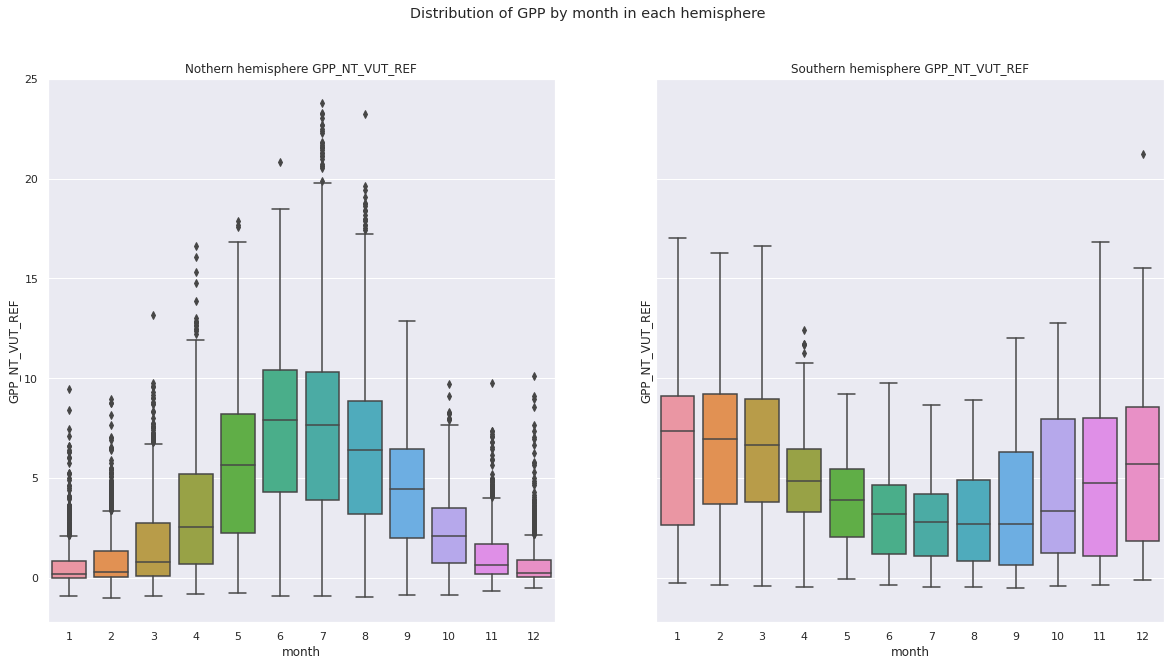

In [97]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of GPP by month in each hemisphere')
sns.boxplot(ax=axes[0], data=monthly_df[monthly_df["hemisphere"] == "N"], x='month', y='GPP_NT_VUT_REF').set(title='Nothern hemisphere GPP_NT_VUT_REF')
sns.boxplot(ax=axes[1], data=monthly_df[monthly_df["hemisphere"] == "S"], x='month', y='GPP_NT_VUT_REF').set(title='Southern hemisphere GPP_NT_VUT_REF')

[Text(0.5, 1.0, 'Southern hemisphere TA_F')]

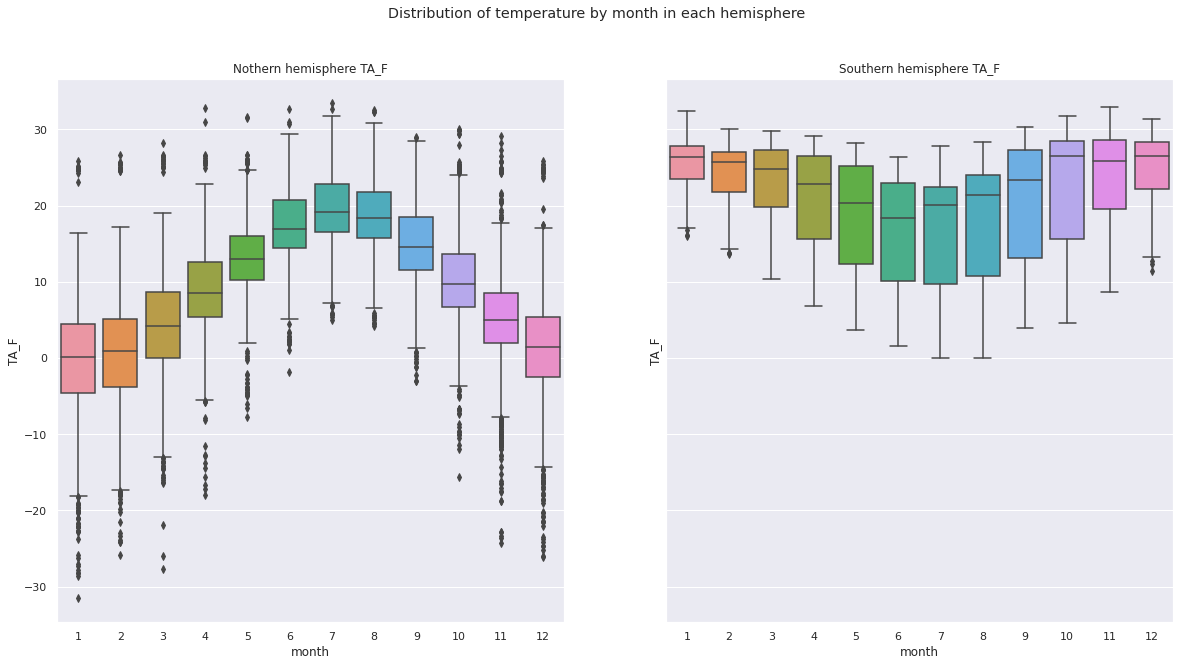

In [98]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of temperature by month in each hemisphere')
sns.boxplot(ax=axes[0], data=monthly_df[monthly_df["hemisphere"] == "N"], x='month', y='TA_F').set(title='Nothern hemisphere TA_F')
sns.boxplot(ax=axes[1], data=monthly_df[monthly_df["hemisphere"] == "S"], x='month', y='TA_F').set(title='Southern hemisphere TA_F')

---
*Following process use only Spark(N0 PANDAS)*

# Use parquet -> Spark df as preparation for global data

## DF to Parquet format
- Pandas is converted to parquet in order to make the following code usable with global data in AWS

In [99]:
type(monthly_df)

pandas.core.frame.DataFrame

### Method 1

In [100]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [101]:
monthly_df.to_parquet('monthly_df_pq', engine='fastparquet')

### Method 2

In [102]:
# Convert df to parquet
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
table = pa.Table.from_pandas(monthly_df)
# Second, write the table into parquet file say file_name.parquet
# Parquet with Brotli compression
pq.write_table(table, 'monthly_df_pq.parquet')

## parquet to Spark df 

In [106]:
# Parquet is read from 
# When running Spark in AWS through the access to Azure, update the location and file name 
monthly_sdf = spark.read.parquet('monthly_df_pq')

In [107]:
monthly_sdf.printSchema()

root
 |-- SITE_ID: string (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- TIMESTAMP: long (nullable = true)
 |-- dataset: string (nullable = true)
 |-- SITE_IGBP: string (nullable = true)
 |-- LOCATION_LAT: double (nullable = true)
 |-- LOCATION_LONG: double (nullable = true)
 |-- TA_F: double (nullable = true)
 |-- VPD_F: double (nullable = true)
 |-- P_F: double (nullable = true)
 |-- NETRAD: double (nullable = true)
 |-- NEE_VUT_REF: double (nullable = true)
 |-- NEE_VUT_REF_QC: double (nullable = true)
 |-- NEE_CUT_REF: double (nullable = true)
 |-- NEE_CUT_REF_QC: double (nullable = true)
 |-- GPP_NT_VUT_REF: double (nullable = true)
 |-- GPP_DT_VUT_REF: double (nullable = true)
 |-- GPP_NT_CUT_REF: double (nullable = true)
 |-- GPP_DT_CUT_REF: double (nullable = true)
 |-- RECO_NT_VUT_REF: double (nullable = true)
 |-- RECO_DT_VUT_REF: double (nullable = true)
 |-- RECO_NT_CUT_REF: double (nullable = true)
 |-- RECO_DT_CUT_REF: double (

In [108]:
monthly_sdf.show(truncate=False)

+-------+----+-----+---------+-------+---------+------------+-------------+------+------+-----+-----------+-----------+--------------+-----------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+--------+---------+--------+------------+---------+-------------+------------+------------+---------+---------+-----------+----------+-----------+----------+--------+-----------+----------+-----------+-----------+----------+----------+-----------+----------+---------+----------+------------+-----------+----------+------------+----+---+-------+---------+----------+---------+----------+---------+-----------------+----------+
|SITE_ID|year|month|TIMESTAMP|dataset|SITE_IGBP|LOCATION_LAT|LOCATION_LONG|TA_F  |VPD_F |P_F  |NETRAD     |NEE_VUT_REF|NEE_VUT_REF_QC|NEE_CUT_REF|NEE_CUT_REF_QC|GPP_NT_VUT_REF|GPP_DT_VUT_REF|GPP_NT_CUT_REF|GPP_DT_CUT_REF|RECO_NT_VUT_REF|RECO_DT_VUT_REF|RECO_NT_CUT_REF|RECO_DT_CUT_REF|tim

In [109]:
display(monthly_sdf)

DataFrame[SITE_ID: string, year: bigint, month: bigint, TIMESTAMP: bigint, dataset: string, SITE_IGBP: string, LOCATION_LAT: double, LOCATION_LONG: double, TA_F: double, VPD_F: double, P_F: double, NETRAD: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, time: string, ET: double, BESS-PAR: bigint, BESS-PARdiff: bigint, BESS-RSDN: bigint, CSIF-SIFdaily: double, CSIF-SIFinst: double, PET: double, Ts: double, Tmean: double, prcp: double, vpd: double, prcp-lag3: double, ESACCI-sm: double, MODIS_LC: bigint, b1: double, b2: double, b3: double, b4: double, b5: double, b6: double, b7: double, EVI: double, GCI: double, NDVI: double, NDWI: double, NIRv: double, kNDVI: double, Percent_Snow: double, Fpar: double, Lai: double, LST_Day: double, LST_Night: dou

In [110]:
print(type(monthly_sdf))

<class 'pyspark.sql.dataframe.DataFrame'>


# Correlation among features with pyspark

In [111]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [112]:
monthly_sdf.columns

['SITE_ID',
 'year',
 'month',
 'TIMESTAMP',
 'dataset',
 'SITE_IGBP',
 'LOCATION_LAT',
 'LOCATION_LONG',
 'TA_F',
 'VPD_F',
 'P_F',
 'NETRAD',
 'NEE_VUT_REF',
 'NEE_VUT_REF_QC',
 'NEE_CUT_REF',
 'NEE_CUT_REF_QC',
 'GPP_NT_VUT_REF',
 'GPP_DT_VUT_REF',
 'GPP_NT_CUT_REF',
 'GPP_DT_CUT_REF',
 'RECO_NT_VUT_REF',
 'RECO_DT_VUT_REF',
 'RECO_NT_CUT_REF',
 'RECO_DT_CUT_REF',
 'time',
 'ET',
 'BESS-PAR',
 'BESS-PARdiff',
 'BESS-RSDN',
 'CSIF-SIFdaily',
 'CSIF-SIFinst',
 'PET',
 'Ts',
 'Tmean',
 'prcp',
 'vpd',
 'prcp-lag3',
 'ESACCI-sm',
 'MODIS_LC',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'EVI',
 'GCI',
 'NDVI',
 'NDWI',
 'NIRv',
 'kNDVI',
 'Percent_Snow',
 'Fpar',
 'Lai',
 'LST_Day',
 'LST_Night',
 'MODIS_IGBP',
 'MODIS_PFT',
 'koppen_sub',
 'koppen',
 'CO2_concentration',
 'hemisphere']

## Choose features to see correlations

In [113]:
# Features used for this analysis

output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_CUT_REF', 'GPP_NT_VUT_REF',
                      'GPP_DT_VUT_REF', 'GPP_NT_CUT_REF','GPP_DT_CUT_REF',
                      'RECO_NT_VUT_REF', 'RECO_DT_VUT_REF', 
                      'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF']

# predictor variables
pred_var_numeric = ['TA_F', 'VPD_F', 'P_F', 'NETRAD','ET',
                    'BESS-PAR', 'BESS-PARdiff','BESS-RSDN', 
                    'CSIF-SIFdaily', 'CSIF-SIFinst','PET', 'Ts', 'Tmean',
                    'prcp', 'vpd', 'prcp-lag3', 'ESACCI-sm',
                    'b1', 'b2', 'b3','b4', 'b5', 'b6', 'b7', 
                    'EVI', 'GCI', 'NDVI', 'NDWI', 'NIRv', 'kNDVI',
                    'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 
                    'CO2_concentration']

pred_var_categorical = ['MODIS_LC', 'MODIS_IGBP','MODIS_PFT', 'koppen_sub', 'koppen']

other_var =  ['SITE_ID', 'year', 'month', 'TIMESTAMP', 'dataset', 'SITE_IGBP',
              'LOCATION_LAT', 'LOCATION_LONG','time']

qc_flags = ['NEE_VUT_REF_QC', 'NEE_CUT_REF_QC'] 

NA_list = []

len(output_related_var + pred_var_numeric + pred_var_categorical 
    + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

62

In [114]:
# Features to observe correlation
corr_list = [output_var] + pred_var_numeric

## Result of full df

In [117]:
monthly_df_corr = monthly_sdf.select(corr_list)

col_names = monthly_df_corr.columns
features = monthly_df_corr.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,GPP_NT_VUT_REF,TA_F,VPD_F,P_F,NETRAD,ET,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,...,NDVI,NDWI,NIRv,kNDVI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,CO2_concentration
GPP_NT_VUT_REF,1.000000,0.507895,0.117540,NaN,NaN,NaN,0.391985,0.472149,0.470907,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384642,0.530571,0.053558
TA_F,0.507895,1.000000,0.728267,NaN,NaN,NaN,0.562405,0.455076,0.761525,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.938068,0.973990,0.041147
VPD_F,0.117540,0.728267,1.000000,NaN,NaN,NaN,0.530830,0.277519,0.764030,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.825925,0.647925,0.013453
P_F,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NETRAD,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ET,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BESS-PAR,0.391985,0.562405,0.530830,NaN,NaN,NaN,1.000000,0.908654,0.678235,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.610409,0.523222,0.217424
BESS-PARdiff,0.472149,0.455076,0.277519,NaN,NaN,NaN,0.908654,1.000000,0.512934,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.439510,0.435404,0.226307
BESS-RSDN,0.470907,0.761525,0.764030,NaN,NaN,NaN,0.678235,0.512934,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.848595,0.705370,-0.028579
CSIF-SIFdaily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
type(monthly_df_corr)

pyspark.sql.dataframe.DataFrame

## Divide feature with None and feature without None

In [119]:
display(monthly_df_corr.head(5))

[Row(GPP_NT_VUT_REF=10.2095, TA_F=28.493, VPD_F=23.378, P_F=0.903, NETRAD=188.598814, ET=9.01454, BESS-PAR=154, BESS-PARdiff=40, BESS-RSDN=336, CSIF-SIFdaily=0.20432499, CSIF-SIFinst=0.51662683, PET=-0.013386652, Ts=302.46967, Tmean=300.10977, prcp=0.002115019, vpd=2.06618, prcp-lag3=0.008738702, ESACCI-sm=0.15152083, b1=0.0844258, b2=0.26877418, b3=0.045316122, b4=0.08052903, b5=0.30057743, b6=0.2505258, b7=0.15535806, EVI=0.32125923, GCI=2.3492026, NDVI=0.5227052, NDWI=0.035415366, NIRv=0.14050612, kNDVI=0.26745087, Percent_Snow=0.0, Fpar=0.49, Lai=1.2, LST_Day=313.84, LST_Night=293.58, CO2_concentration=387.11),
 Row(GPP_NT_VUT_REF=8.16307, TA_F=26.673, VPD_F=14.369, P_F=1.986, NETRAD=144.2162024, ET=7.6779733, BESS-PAR=120, BESS-PARdiff=46, BESS-RSDN=258, CSIF-SIFdaily=0.1455303, CSIF-SIFinst=0.38726252, PET=-0.008937791, Ts=298.78864, Tmean=297.27515, prcp=0.003131761, vpd=1.0901145, prcp-lag3=0.009724296, ESACCI-sm=0.16655783, b1=0.0918, b2=0.2524464, b3=0.04803214, b4=0.08092143

In [120]:
# code that counts the number of None in each feature
from pyspark.sql.functions import isnull, when, count, col

monthly_df_corr.select([count(when(isnull(c), c)).alias(c) for c in monthly_df_corr.columns]).show()

+--------------+----+-----+---+------+---+--------+------------+---------+-------------+------------+---+---+-----+----+---+---------+---------+---+---+---+---+---+---+---+----+---+----+----+----+-----+------------+----+---+-------+---------+-----------------+
|GPP_NT_VUT_REF|TA_F|VPD_F|P_F|NETRAD| ET|BESS-PAR|BESS-PARdiff|BESS-RSDN|CSIF-SIFdaily|CSIF-SIFinst|PET| Ts|Tmean|prcp|vpd|prcp-lag3|ESACCI-sm| b1| b2| b3| b4| b5| b6| b7| EVI|GCI|NDVI|NDWI|NIRv|kNDVI|Percent_Snow|Fpar|Lai|LST_Day|LST_Night|CO2_concentration|
+--------------+----+-----+---+------+---+--------+------------+---------+-------------+------------+---+---+-----+----+---+---------+---------+---+---+---+---+---+---+---+----+---+----+----+----+-----+------------+----+---+-------+---------+-----------------+
|             0|   0|    0|353|  2693| 32|       0|           0|        0|          121|         121|101|101|  101| 101|101|      101|     1610|406|399|406|406|406|406|406|1620|469| 452| 406| 452|  406|         143| 9

## Create two lists - list of features with noNA/NA

In [121]:
monthly_df_countNA = pd.DataFrame(monthly_df[corr_list].isna().sum())
monthly_df_countNA = pd.DataFrame(monthly_df[corr_list].isna().sum())

corr_NA0_list = list(monthly_df_countNA[monthly_df_countNA[0] == 0].index)
corr_NA_list = list(monthly_df_countNA[monthly_df_countNA[0] != 0].index)

In [122]:
corr_NA_list

['P_F',
 'NETRAD',
 'ET',
 'CSIF-SIFdaily',
 'CSIF-SIFinst',
 'PET',
 'Ts',
 'Tmean',
 'prcp',
 'vpd',
 'prcp-lag3',
 'ESACCI-sm',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'EVI',
 'GCI',
 'NDVI',
 'NDWI',
 'NIRv',
 'kNDVI',
 'Percent_Snow',
 'Fpar',
 'Lai']

In [123]:
corr_NA0_list

['GPP_NT_VUT_REF',
 'TA_F',
 'VPD_F',
 'BESS-PAR',
 'BESS-PARdiff',
 'BESS-RSDN',
 'LST_Day',
 'LST_Night',
 'CO2_concentration']

## Correlation of features with zero NA

In [124]:
monthly_df_corr2 = monthly_sdf.select(corr_NA0_list)

col_names = monthly_df_corr2.columns
features = monthly_df_corr2.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df2 = pd.DataFrame(corr_mat)
corr_df2.index, corr_df2.columns = col_names, col_names
corr_df2

,GPP_NT_VUT_REF,TA_F,VPD_F,BESS-PAR,BESS-PARdiff,BESS-RSDN,LST_Day,LST_Night,CO2_concentration
GPP_NT_VUT_REF,1.000000,0.507895,0.117540,0.391985,0.472149,0.470907,0.384642,0.530571,0.053558
TA_F,0.507895,1.000000,0.728267,0.562405,0.455076,0.761525,0.938068,0.973990,0.041147
VPD_F,0.117540,0.728267,1.000000,0.530830,0.277519,0.764030,0.825925,0.647925,0.013453
BESS-PAR,0.391985,0.562405,0.530830,1.000000,0.908654,0.678235,0.610409,0.523222,0.217424
BESS-PARdiff,0.472149,0.455076,0.277519,0.908654,1.000000,0.512934,0.439510,0.435404,0.226307
BESS-RSDN,0.470907,0.761525,0.764030,0.678235,0.512934,1.000000,0.848595,0.705370,-0.028579
LST_Day,0.384642,0.938068,0.825925,0.610409,0.439510,0.848595,1.000000,0.897132,0.040576
LST_Night,0.530571,0.973990,0.647925,0.523222,0.435404,0.705370,0.897132,1.000000,0.033247
CO2_concentration,0.053558,0.041147,0.013453,0.217424,0.226307,-0.028579,0.040576,0.033247,1.000000


## Correlation table 1 - full observations
 - None of the observations are dropped because of NA 

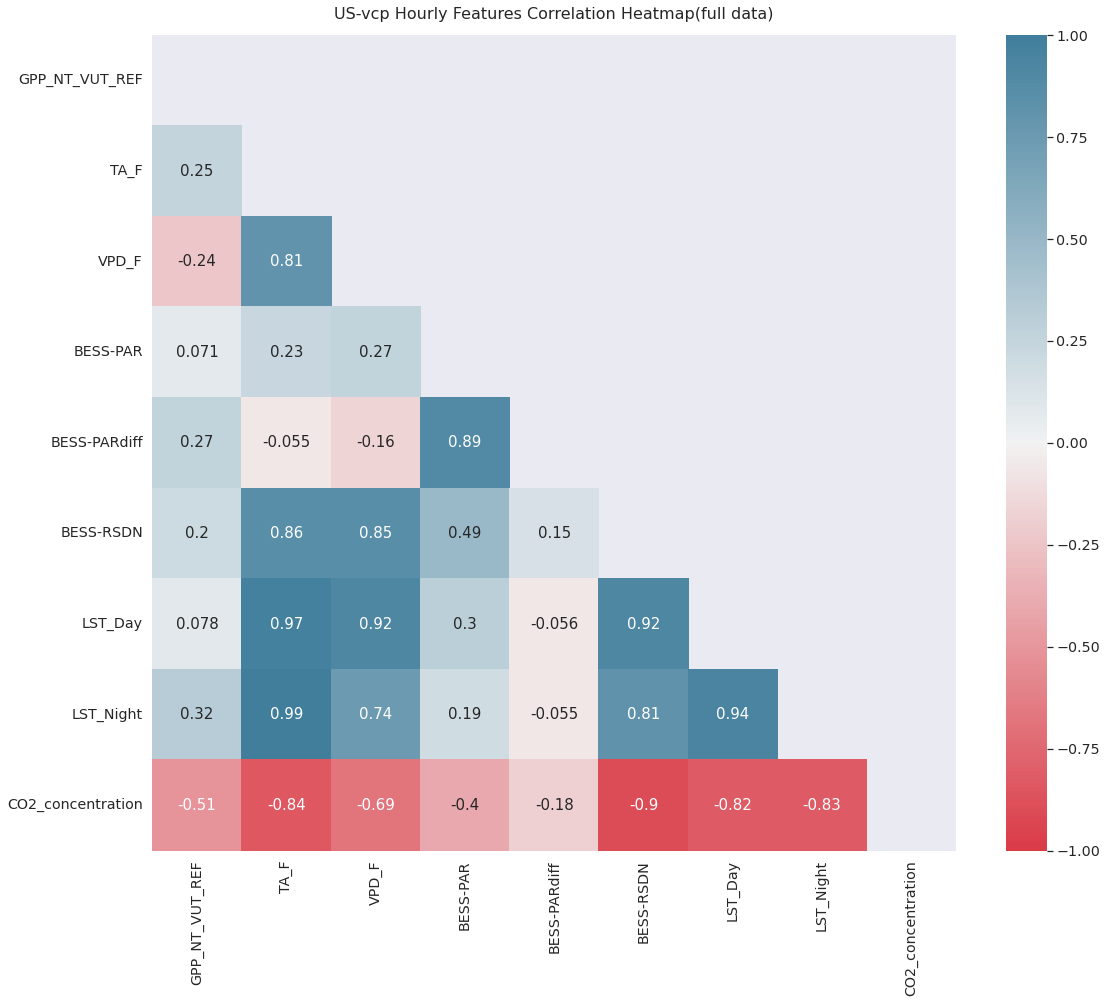

In [125]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df2)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

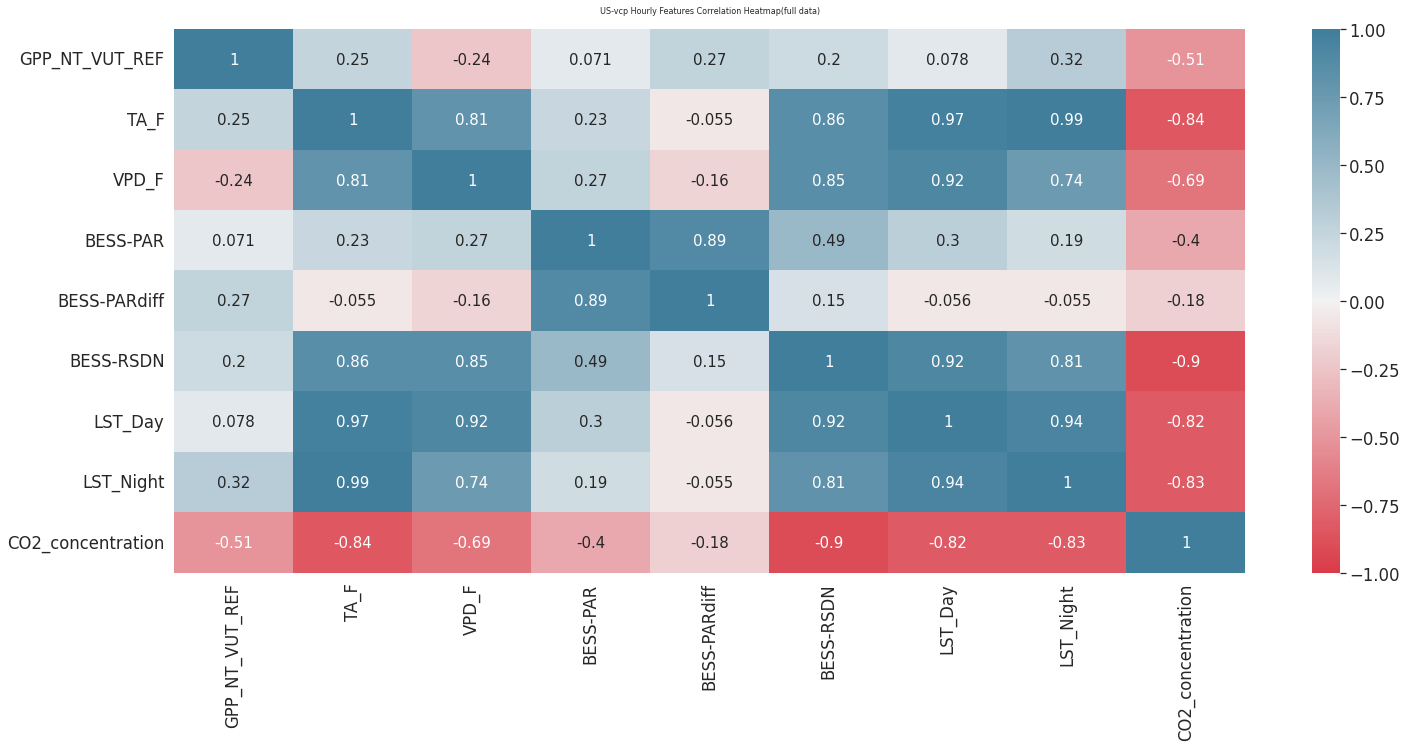

In [126]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':8}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


## Correlation table 2 - drop rows with NA

In [127]:
monthly_df_corr3 = monthly_sdf.select(corr_list)

### Drop NA-contained rows

In [128]:
monthly_df_corr3_NAdrop = monthly_df_corr3.na.drop("any")
monthly_df_corr3_NAdrop.show()

+--------------+------+------+-----+-----------+---------+--------+------------+---------+-------------+------------+------------+---------+---------+-----------+----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-----------+----------+---------+----------+------------+-----------+----------+------------+----+---+-------+---------+-----------------+
|GPP_NT_VUT_REF|  TA_F| VPD_F|  P_F|     NETRAD|       ET|BESS-PAR|BESS-PARdiff|BESS-RSDN|CSIF-SIFdaily|CSIF-SIFinst|         PET|       Ts|    Tmean|       prcp|       vpd|  prcp-lag3| ESACCI-sm|         b1|        b2|         b3|         b4|        b5|        b6|         b7|       EVI|      GCI|      NDVI|        NDWI|       NIRv|     kNDVI|Percent_Snow|Fpar|Lai|LST_Day|LST_Night|CO2_concentration|
+--------------+------+------+-----+-----------+---------+--------+------------+---------+-------------+------------+------------+---------+---------+-----------+----------+-----------+-------

Rows were reduced from 174528 -> 104846

In [129]:
rows = monthly_df_corr3_NAdrop.count()
print(f"DataFrame Rows count : {rows}")

DataFrame Rows count : 12937


In [130]:
col_names = monthly_df_corr3_NAdrop.columns
features = monthly_df_corr3_NAdrop.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df3_NAdrop = pd.DataFrame(corr_mat)
corr_df3_NAdrop.index, corr_df3_NAdrop.columns = col_names, col_names
corr_df3_NAdrop

,GPP_NT_VUT_REF,TA_F,VPD_F,P_F,NETRAD,ET,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,...,NDVI,NDWI,NIRv,kNDVI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,CO2_concentration
GPP_NT_VUT_REF,1.000000,0.437661,0.030005,0.249369,0.564795,0.662947,0.334830,0.474028,0.393978,0.808107,...,0.658316,0.393620,0.771728,0.679588,-0.308570,0.704951,0.753077,0.271508,0.474187,0.035134
TA_F,0.437661,1.000000,0.745049,0.089683,0.711858,0.540968,0.607369,0.472254,0.750576,0.447734,...,0.207663,-0.255287,0.417605,0.212378,-0.594478,0.282484,0.393819,0.923820,0.969599,0.051543
VPD_F,0.030005,0.745049,1.000000,-0.222813,0.565661,0.237032,0.590886,0.273730,0.758797,-0.000370,...,-0.282071,-0.464365,-0.052250,-0.269326,-0.300834,-0.181786,-0.029978,0.853329,0.655917,0.055917
P_F,0.249369,0.089683,-0.222813,1.000000,0.029163,0.213213,-0.074980,0.120165,-0.097664,0.294754,...,0.361506,0.242816,0.322484,0.362645,-0.067771,0.302908,0.288826,-0.057653,0.161777,-0.081322
NETRAD,0.564795,0.711858,0.565661,0.029163,1.000000,0.739431,0.715398,0.646980,0.904255,0.539207,...,0.225993,-0.047147,0.435642,0.238635,-0.360359,0.337139,0.482712,0.710885,0.674466,0.024319
ET,0.662947,0.540968,0.237032,0.213213,0.739431,1.000000,0.488479,0.541452,0.632391,0.665021,...,0.429870,0.190195,0.592207,0.429806,-0.264274,0.512450,0.622749,0.432444,0.564202,-0.063293
BESS-PAR,0.334830,0.607369,0.590886,-0.074980,0.715398,0.488479,1.000000,0.864642,0.750897,0.319772,...,0.007789,-0.171459,0.236488,0.021254,-0.285662,0.112429,0.247284,0.667006,0.558376,0.169316
BESS-PARdiff,0.474028,0.472254,0.273730,0.120165,0.646980,0.541452,0.864642,1.000000,0.550305,0.516650,...,0.242923,0.075929,0.435332,0.255928,-0.223715,0.298225,0.409331,0.434730,0.454478,0.156739
BESS-RSDN,0.393978,0.750576,0.758797,-0.097664,0.904255,0.632391,0.750897,0.550305,1.000000,0.366652,...,-0.019870,-0.237552,0.258140,-0.000534,-0.349329,0.114834,0.296408,0.842095,0.689081,0.008653
CSIF-SIFdaily,0.808107,0.447734,-0.000370,0.294754,0.539207,0.665021,0.319772,0.516650,0.366652,1.000000,...,0.753127,0.452110,0.968245,0.776082,-0.324624,0.772342,0.831552,0.261362,0.481969,0.022076


## Correlation table 2 - NA dropped
 - Apply all the possible features
 - Instead, row that include NA are dropped from DF 

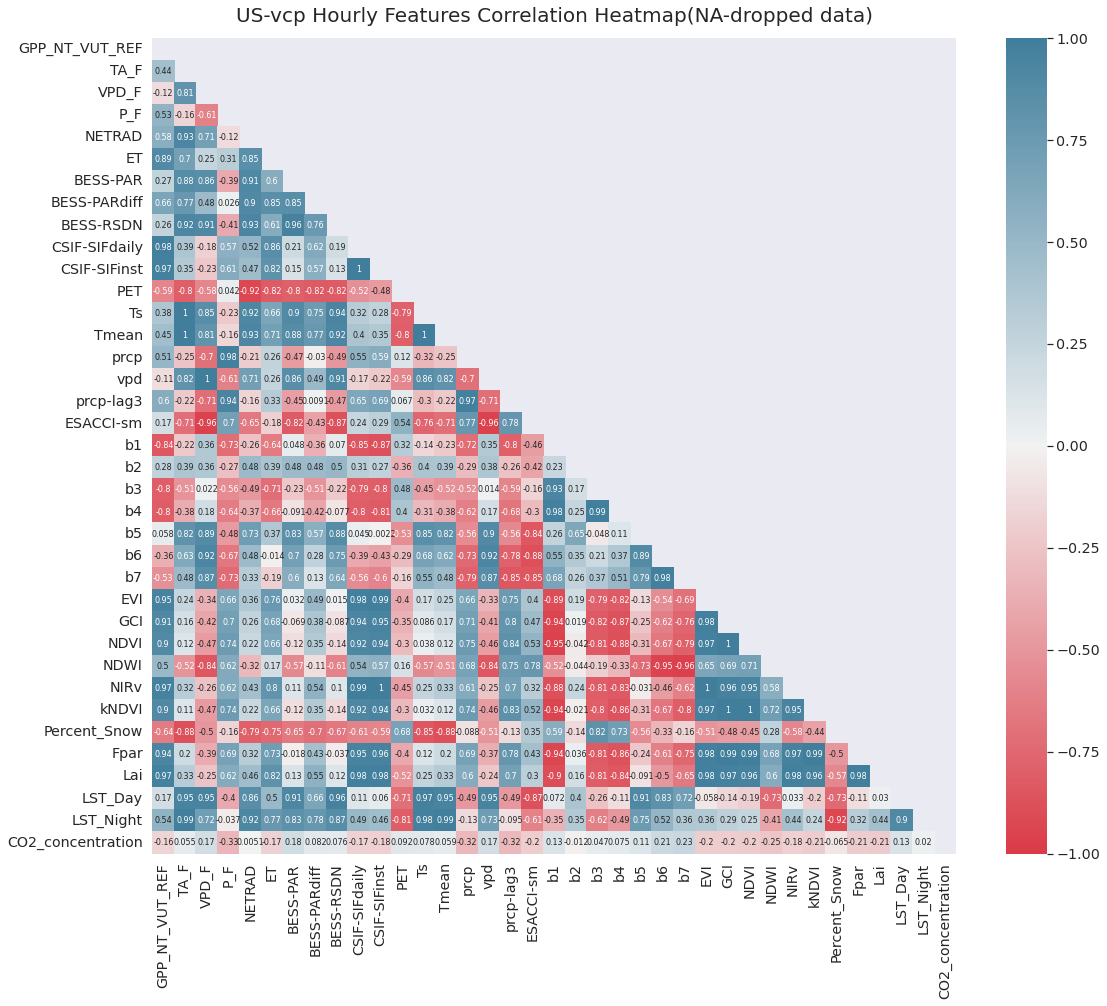

In [131]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df3_NAdrop)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":8}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':20}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

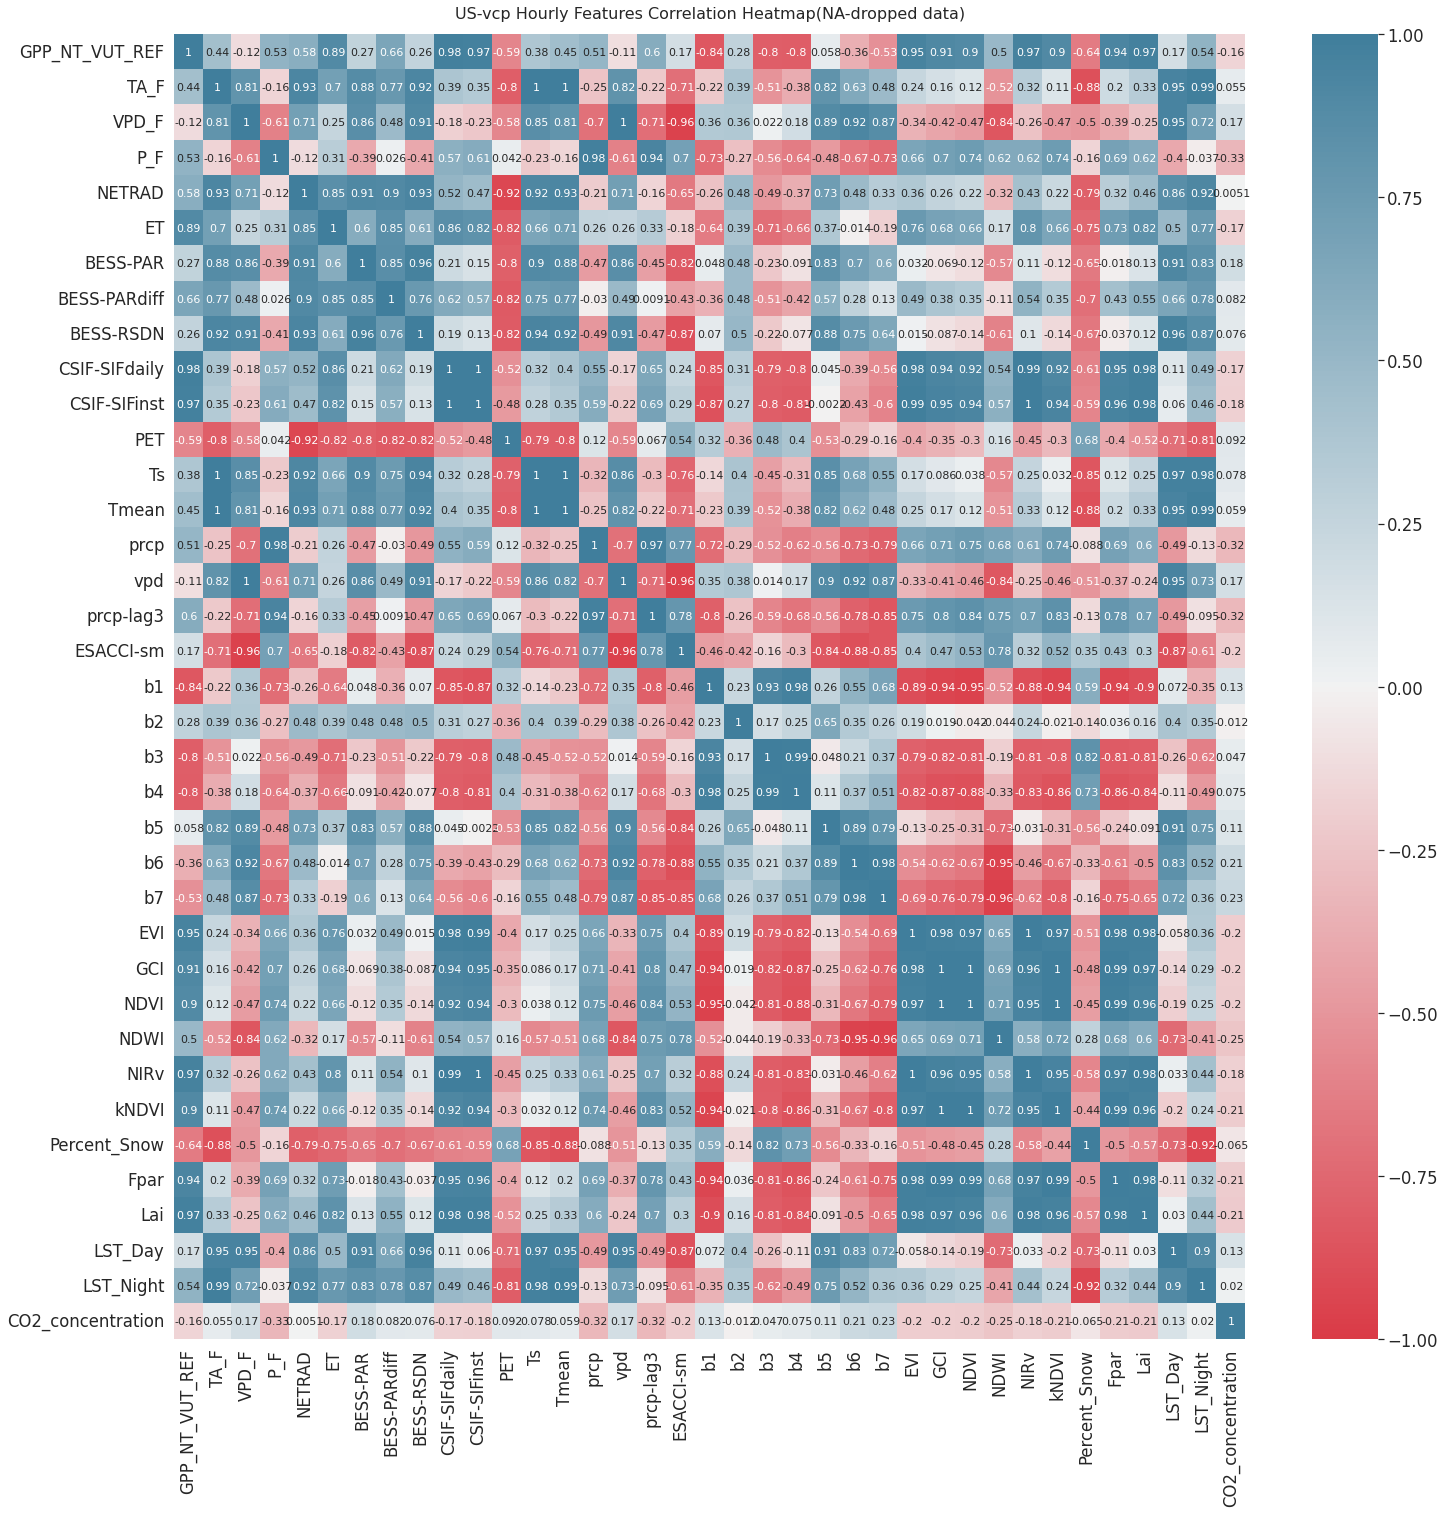

In [133]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 24))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":11})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


# Correlation with other categorical features

(To be updated)